In [1]:
import os
import torch
import torchvision
import torch.nn as nn 
from torchvision import transforms
from torchvision.utils import save_image


In [4]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
input_size=784
num_epochs=40
batch_size=80
sample_dir="samples"
learning_rate_e=.01
learning_rate_de=.01
learning_rate_di=.002
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
transform= transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))]) 
data=torchvision.datasets.MNIST(root='Data',transform=transform,train=True,download=True)
data_loader=torch.utils.data.DataLoader(dataset=data,shuffle=True,batch_size=batch_size)
class Encoder(nn.Module):
     def __init__(self):
            super(Encoder,self).__init__()
            self.fc1=nn.Linear(784,400)
            self.fc2=nn.Linear(400,100)
            self.fc3=nn.Linear(100,2)
            self.relu=nn.ReLU()
     def forward(self,x):
        out=self.fc1(x)
        out=self.relu(out)
        out=self.fc2(out)
        out=self.relu(out)
        out=self.fc3(out)
        out=self.relu(out)
        return (out)
class Decoder(nn.Module):
     def __init__(self):
            super(Decoder,self).__init__()
            self.fc1=nn.Linear(2,100)
            self.fc2=nn.Linear(100,400)
            self.fc3=nn.Linear(400,784)
            self.relu=nn.ReLU()
            self.sigmoid=nn.Sigmoid()
     def forward(self,x):
        out=self.fc1(x)
        out=self.relu(out)
        out=self.fc2(out)
        out=self.relu(out)
        out=self.fc3(out)
        out=self.sigmoid(out)
        return (out)
class Discriminator(nn.Module):
     def __init__(self):
            super(Discriminator,self).__init__()
            self.fc1=nn.Linear(2,10)
            self.fc2=nn.Linear(10,10)
            self.fc3=nn.Linear(10,1)
            self.relu=nn.ReLU()
            self.sigmoid=nn.Sigmoid()
     def forward(self,x):
        out=self.fc1(x)
        out=self.relu(out)
        out=self.fc2(out)
        out=self.relu(out)
        out=self.fc3(out)
        out=self.sigmoid(out)
        return (out)
model_encoder=Encoder().to(device)
model_decoder=Decoder().to(device)
model_discriminator=Discriminator().to(device)
criterion_discriminator=nn.BCELoss()
criterion_autoencoder=nn.L1Loss()
optimizer_encoder=torch.optim.Adam(model_encoder.parameters(),lr=learning_rate_e)
optimizer_discriminator=torch.optim.Adam(model_discriminator.parameters(),lr=learning_rate_di)
optimizer_decoder=torch.optim.Adam(model_decoder.parameters(),lr=learning_rate_de)


In [7]:
total_step=len(data_loader)
generator_loss = []
discriminator_loss = []
discriminator_acc = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(data_loader):
        acc = 0
        images = images.reshape(-1, 784).to(device)
        
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        #Training autoencoder here 
        encoded = model_encoder(images)
        decoded = model_decoder(encoded)
        
        loss_encoder = 0.001*criterion_discriminator(model_discriminator(encoded), real_labels)+0.999*criterion_autoencoder(decoded, images)
        optimizer_encoder.zero_grad()
        loss_encoder.backward(retain_graph = True)
        optimizer_encoder.step()
        loss_decoder = criterion_autoencoder(decoded, images)
        optimizer_decoder.zero_grad()
        loss_decoder.backward(retain_graph=True)
        optimizer_decoder.step()
        #Training discriminator here
        z = torch.randn(batch_size, 2).to(device)
        real_output = model_discriminator(z)
        real_loss = criterion_discriminator(real_output, real_labels)
        fake_output = model_discriminator(encoded)
        fake_loss = criterion_discriminator(fake_output, fake_labels)
        loss = 0.5*(fake_loss+real_loss)
        
        optimizer_discriminator.zero_grad()
        loss.backward(retain_graph=True)
        optimizer_discriminator.step()
        
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Discriminator_loss: {:.4f}, Encoder_loss: {:.4f}, Decoder_loss: {:.4f} ' 
                  .format(epoch, num_epochs, i+1, total_step, loss.item(), loss_encoder.item(), loss_decoder.item()))
        
        if (epoch == num_epochs-1):
            decoded = decoded.reshape(decoded.size(0),1,28,28)
            for j in range(decoded.size(0)):
                save_image(decoded[j], os.path.join(sample_dir, 'fake_images-{}.png'.format(j)))
    generator_loss.append(loss_encoder.item())
    discriminator_loss.append(loss.item())
    discriminator_acc.append(float(acc)/float(2*batch_size))

Epoch [0/40], Step [200/750], Discriminator_loss: 0.0535, Encoder_loss: 0.9462, Decoder_loss: 0.9448 
Epoch [0/40], Step [400/750], Discriminator_loss: 0.0459, Encoder_loss: 0.9452, Decoder_loss: 0.9437 
Epoch [0/40], Step [600/750], Discriminator_loss: 0.0485, Encoder_loss: 0.9465, Decoder_loss: 0.9449 
Epoch [1/40], Step [200/750], Discriminator_loss: 0.0289, Encoder_loss: 0.9477, Decoder_loss: 0.9458 
Epoch [1/40], Step [400/750], Discriminator_loss: 0.0250, Encoder_loss: 0.9492, Decoder_loss: 0.9472 
Epoch [1/40], Step [600/750], Discriminator_loss: 0.0218, Encoder_loss: 0.9470, Decoder_loss: 0.9448 
Epoch [2/40], Step [200/750], Discriminator_loss: 0.0174, Encoder_loss: 0.9471, Decoder_loss: 0.9446 
Epoch [2/40], Step [400/750], Discriminator_loss: 0.0215, Encoder_loss: 0.9474, Decoder_loss: 0.9448 
Epoch [2/40], Step [600/750], Discriminator_loss: 0.0137, Encoder_loss: 0.9488, Decoder_loss: 0.9461 
Epoch [3/40], Step [200/750], Discriminator_loss: 0.0110, Encoder_loss: 0.9470, De

Epoch [26/40], Step [600/750], Discriminator_loss: 0.0000, Encoder_loss: 0.9544, Decoder_loss: 0.9458 
Epoch [27/40], Step [200/750], Discriminator_loss: 0.0000, Encoder_loss: 0.9545, Decoder_loss: 0.9459 
Epoch [27/40], Step [400/750], Discriminator_loss: 0.0003, Encoder_loss: 0.9496, Decoder_loss: 0.9432 
Epoch [27/40], Step [600/750], Discriminator_loss: 0.0000, Encoder_loss: 0.9548, Decoder_loss: 0.9462 
Epoch [28/40], Step [200/750], Discriminator_loss: 0.0000, Encoder_loss: 0.9558, Decoder_loss: 0.9472 
Epoch [28/40], Step [400/750], Discriminator_loss: 0.0000, Encoder_loss: 0.9566, Decoder_loss: 0.9479 
Epoch [28/40], Step [600/750], Discriminator_loss: 0.0000, Encoder_loss: 0.9541, Decoder_loss: 0.9454 
Epoch [29/40], Step [200/750], Discriminator_loss: 0.0000, Encoder_loss: 0.9551, Decoder_loss: 0.9463 
Epoch [29/40], Step [400/750], Discriminator_loss: 0.0000, Encoder_loss: 0.9549, Decoder_loss: 0.9462 
Epoch [29/40], Step [600/750], Discriminator_loss: 0.0000, Encoder_loss: 

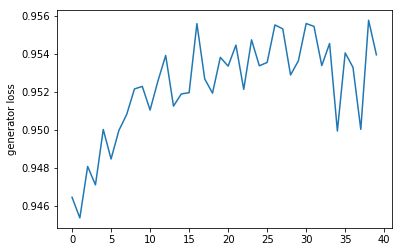

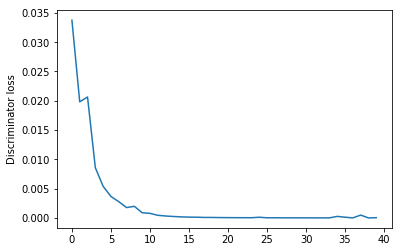

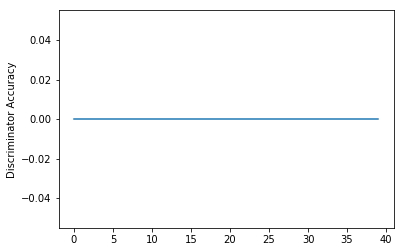

In [9]:
import matplotlib.pyplot as plt

plt.plot(generator_loss)
plt.ylabel("generator loss")
plt.show()
plt.plot(discriminator_loss)
plt.ylabel("Discriminator loss")
plt.show()
# print(discriminator_acc)
plt.plot(discriminator_acc)
plt.ylabel("Discriminator Accuracy")
plt.show()
